Download and unzip data

In [25]:
import os


if not os.path.exists("/content/dataset"):
    !gdown 1unYoVuSLU0amPRsZGbDv9n58LIuENYFO
    !unzip data.zip -d dataset

#todo setup pretrained segmentation network
#! git clone https://github.com/AniketP04/Skin-Cancer-Lesion-Segmentation.git

In [26]:
import numpy as np
import pathlib
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms, datasets
import json
from tqdm.notebook import tqdm
from torch import nn, optim
from sklearn import svm
from joblib import parallel_backend
import cv2
from matplotlib import pyplot as plt


# **Setup**
Set parameters as desired to run noteboook

In [27]:
#Run hair removal algor to remove hair within image
remove_hair = True
#crop border around image of size crop
crop = 30
#grid search for best parameters of classification head
grid_search_scv = False
#run get classification head report from lazypredict
classify_head_search = False
#run smoothing with gaussian and median filters (reduces performance)
preprocess_smooth = False
#run none local mean denoising (reduces performance, due to global attention)
denoising = False
#model size for DinoV2 model (small, base, large, giant)
model_type = 'base'
#recompute embeddings (needed if Json is not needed)
recompute = False



### **Preprocessing**

Hair Removal: uses Dull razor algorithm

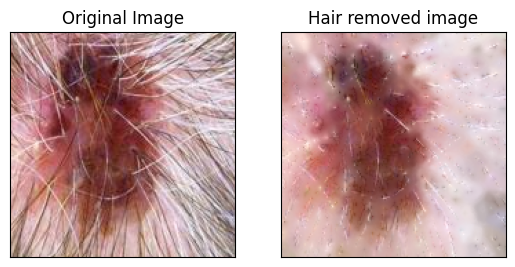

In [28]:
def crop_img(img, crop):
  w,h = img.size[:2]
  img=img.crop((crop, crop, w-crop, h-crop))
  return img

def Dullrazor(img):

  img = np.array(img)
  #DULL RAZOR (REMOVE HAIR)
  #Gray scale
  grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
  #Black hat filter
  kernel = cv2.getStructuringElement(1,(9,9))
  blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
  #Gaussian filter
  bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
  #Binary thresholding (MASK)
  ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
  #Replace pixels of the mask
  result = cv2.inpaint(img,mask,6,cv2.INPAINT_TELEA)
  #convert back to PIL format
  result = Image.fromarray(result)
  return result

#demo algorithm

hair_picture = "/content/dataset/train/Malignant/2031.jpg"
hair_img = Image.open(hair_picture)
hair_img = crop_img(hair_img, crop)
no_hair_img = Dullrazor(hair_img)
f, axarr = plt.subplots(1,2)

axarr[0].imshow(hair_img)
axarr[0].set_title("Original Image")
axarr[1].imshow(no_hair_img)
axarr[1].set_title("Hair removed image")
for ax in axarr:
    ax.set_xticks([])
    ax.set_yticks([])

Preproces Denoising, Smoothing, and histogram equalization

Text(0.5, 1.0, 'Preprocessed Image')

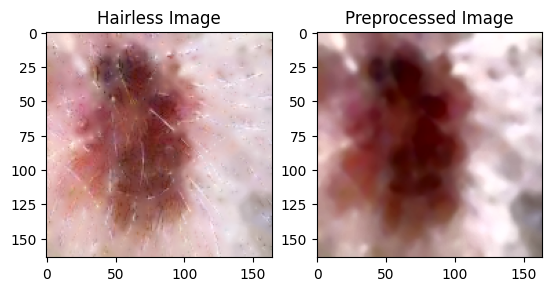

In [29]:
from skimage.restoration import denoise_nl_means, estimate_sigma
import time

def NL_mean_denoising(image):
  dst = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,11)
  return dst

def smooth_filter(image):
  image = cv2.medianBlur(image, 5)
  image = cv2.GaussianBlur(image, (5, 5), 0)
  return image

def histogram_equalization(image):

  # convert from RGB color-space to YCrCb
  ycrcb_img = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

  # equalize the histogram of the Y channel
  ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])

  # convert back to RGB color-space from YCrCb
  equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

  return equalized_img

def preprocess_image(img):

  #start = time.time()
  img = np.array(img)
  #print("convert to mat: ", time.time()-start)
  #start = time.time()
  if denoising:
    img = NL_mean_denoising(img)
  #print("denoising: ", time.time()-start)
  #start = time.time()
  img = smooth_filter(img)
  #print("smoothing: ", time.time()-start)
  #start = time.time()
  img = histogram_equalization(img)
  #print("equalization: ", time.time()-start)
  #start = time.time()
  img = Image.fromarray(img)
  #print("convert back: ", time.time()-start)

  return img

smooth_image = preprocess_image(no_hair_img)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(no_hair_img)
axarr[0].set_title("Hairless Image")
axarr[1].imshow(smooth_image)
axarr[1].set_title("Preprocessed Image")

In [38]:
#CUSTOM DATASET CLASS
def find_classes(directory):

    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


#Subclass torch.utils.data.Dataset
class CustomFolderDataset(Dataset):

    def __init__(self, targ_dir: str, transform=None):

        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)
        #generate ground truth list
        self.gt = [self.class_to_idx[path.parent.name] for path in self.paths]

    def load_image(self, index):
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        img = Image.open(image_path)
        img = crop_img(img, crop)
        if remove_hair:
          img = Dullrazor(img)
        if preprocess_smooth:
          img = preprocess_image(img)
        return img

    def __len__(self):
        "Returns the total number of samples."
        return len(self.paths)

    def __getitem__(self, index):
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        if remove_hair:
          img = Dullrazor(img)

        if self.transform:
            return self.transform(img)[:3].unsqueeze(0), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

Calculate mean and std for zscore normalization

In [31]:
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomRotation(360),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])

])

train = CustomFolderDataset(targ_dir='/content/dataset/train',
                                      transform=train_transforms)
test = CustomFolderDataset(targ_dir='/content/dataset/test',
                                      transform=test_transforms)


print(len(train), len(test))
print(train.classes)
print(train.class_to_idx)



11879 2000
['Benign', 'Malignant']
{'Benign': 0, 'Malignant': 1}


Utilize Dinov2 to compute vector embeddings

In [32]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using: ", device)
if model_type == 'small':
    dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device)
    output_dim = 384
elif model_type == 'base':
    dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14").to(device)
    output_dim = 768
elif model_type == 'large':
    dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitl14").to(device)
    output_dim = 1024
elif model_type == 'giant':
    dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitg14").to(device)
    output_dim = 1536
else:
    raise ValueError("Invalid model type. Must be one of 'small', 'base', or 'large'.")


using:  cuda:0


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [33]:

def compute_embeddings(dataset, train = True, recompute = True):
    """
    Create an index that contains all of the images in the specified list of files.
    """

    if train:
      embedding_file = "train_embeddings_+" + model_type +  ".json"
    else:
      embedding_file = "test_embeddings_" + model_type +  ".json"

    if not recompute:
      if os.path.exists(embedding_file):
          with open(embedding_file, "r") as f:
              return json.loads(f.read())

    all_embeddings = {}

    with torch.no_grad():
      for i in tqdm(range(len(dataset))):
        input = dataset[i][0].to(device)
        embeddings = dinov2(input)

        all_embeddings[i] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open(embedding_file, "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings


train_embeddings = compute_embeddings(train, train = True, recompute=recompute)
test_embeddings = compute_embeddings(test, train = False, recompute=recompute)


PCA: I tested PCA for further dimensionality reduction but performance was degraded

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pca.fit(np.array(list(train_embeddings.values())).reshape(len(train), output_dim))
pca_features_train = pca.transform(np.array(list(train_embeddings.values())).reshape(len(train), output_dim))

pca = PCA(n_components=100)
pca.fit(np.array(list(test_embeddings.values())).reshape(len(test), output_dim))
pca_features_test = pca.transform(np.array(list(test_embeddings.values())).reshape(len(test), output_dim))


Train a support vector classifier for head

In [12]:
clf_svc = svm.SVC(gamma='scale', tol = 1e-4)
train_embedding_list = list(train_embeddings.values())
clf_svc.fit(np.array(train_embedding_list).reshape(-1, output_dim), train.gt)


test_embeddings_list = list(test_embeddings.values())
results = clf_svc.predict(np.array(test_embeddings_list).reshape(-1, output_dim))

              precision    recall  f1-score   support

      Benign       0.84      0.91      0.87      1000
   Malignant       0.90      0.82      0.86      1000

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



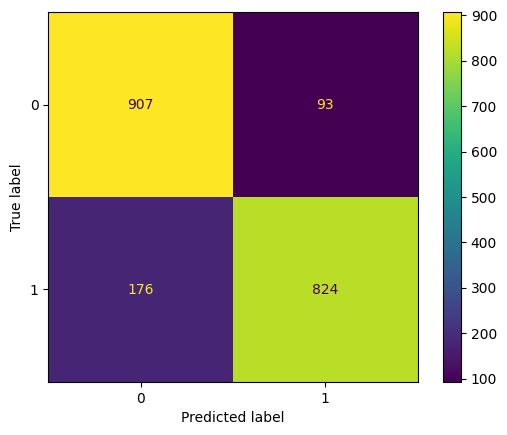

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(test.gt, results, target_names = test.classes))
disp = ConfusionMatrixDisplay(confusion_matrix(test.gt, results))
disp.plot()
plt.show()

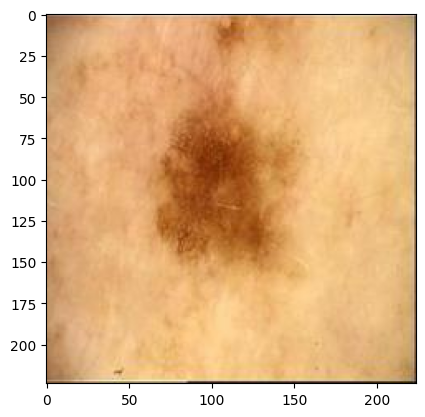

pred:  Malignant gt:  Benign


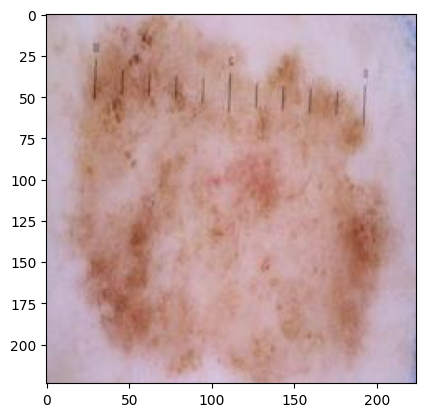

pred:  Malignant gt:  Benign


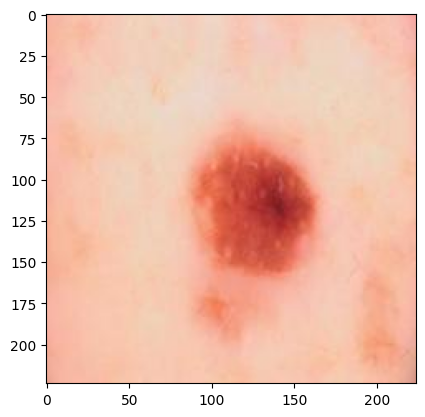

pred:  Malignant gt:  Benign


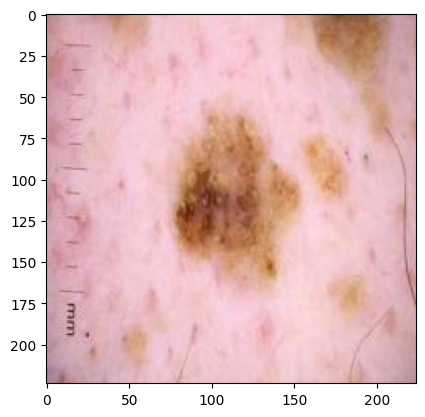

pred:  Malignant gt:  Benign


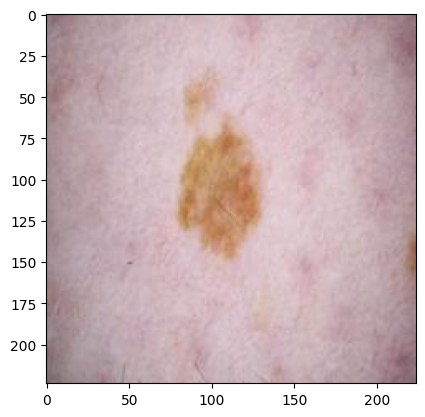

pred:  Malignant gt:  Benign


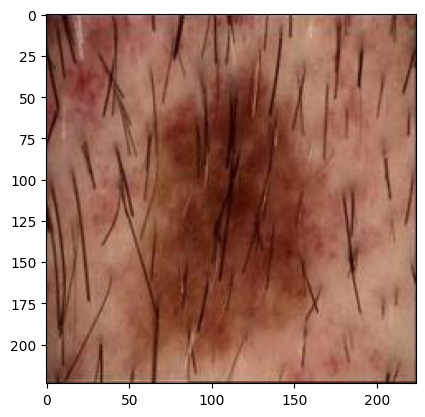

pred:  Malignant gt:  Benign


In [40]:
%matplotlib inline

from matplotlib import pyplot as plt

count = 0
for i, (prediction, gt) in enumerate(zip(results, test.gt)):
  if prediction != gt:
    plt.imshow(Image.open(test.paths[i]))
    plt.show()
    print("pred: ", test.classes[prediction], "gt: ", test.classes[gt])
    count += 1
    if count > 5:
      break

Lazy predict is a quick and easy way to narrow down which classifier to use for a project.

In [46]:

if classify_head_search:
  !pip install lazypredict
  from lazypredict.Supervised import LazyClassifier
  import numpy as np

  train_embedding_list = list(train_embeddings.values())
  test_embeddings_list = list(test_embeddings.values())

  clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)
  models, predictions = clf.fit(np.array(train_embedding_list).reshape(-1, output_dim), np.array(test_embeddings_list).reshape(-1, output_dim), train.gt, test.gt)

  print(models)


  3%|▎         | 1/29 [01:32<43:15, 92.71s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.775, 'Balanced Accuracy': 0.7749999999999999, 'ROC AUC': 0.775, 'F1 Score': 0.7740156120058977, 'Time taken': 92.70511507987976}


  7%|▋         | 2/29 [05:17<1:16:40, 170.39s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.6905, 'Balanced Accuracy': 0.6905, 'ROC AUC': 0.6905000000000001, 'F1 Score': 0.6900405626239494, 'Time taken': 224.7662250995636}


 10%|█         | 3/29 [05:18<40:14, 92.85s/it]   

{'Model': 'BernoulliNB', 'Accuracy': 0.672, 'Balanced Accuracy': 0.672, 'ROC AUC': 0.672, 'F1 Score': 0.6719734298478177, 'Time taken': 0.5826058387756348}


 14%|█▍        | 4/29 [05:39<26:51, 64.48s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.828, 'Balanced Accuracy': 0.8280000000000001, 'ROC AUC': 0.8279999999999998, 'F1 Score': 0.8259701154263328, 'Time taken': 20.9784038066864}


 21%|██        | 6/29 [06:09<14:22, 37.50s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.61, 'Balanced Accuracy': 0.61, 'ROC AUC': 0.61, 'F1 Score': 0.6098279341189465, 'Time taken': 29.976811170578003}


 24%|██▍       | 7/29 [06:09<09:17, 25.36s/it]

{'Model': 'DummyClassifier', 'Accuracy': 0.5, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.3333333333333333, 'Time taken': 0.37061166763305664}


 28%|██▊       | 8/29 [06:10<06:05, 17.43s/it]

{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.5735, 'Balanced Accuracy': 0.5735, 'ROC AUC': 0.5734999999999999, 'F1 Score': 0.5733838537541847, 'Time taken': 0.4387843608856201}


 31%|███       | 9/29 [06:16<04:36, 13.81s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.7605, 'Balanced Accuracy': 0.7605, 'ROC AUC': 0.7605, 'F1 Score': 0.760331692931361, 'Time taken': 5.847261905670166}


 34%|███▍      | 10/29 [06:16<03:04,  9.70s/it]

{'Model': 'GaussianNB', 'Accuracy': 0.6225, 'Balanced Accuracy': 0.6224999999999999, 'ROC AUC': 0.6224999999999999, 'F1 Score': 0.608284548330034, 'Time taken': 0.5057821273803711}


 38%|███▊      | 11/29 [06:17<02:04,  6.93s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.7625, 'Balanced Accuracy': 0.7625, 'ROC AUC': 0.7625000000000001, 'F1 Score': 0.7614766753062325, 'Time taken': 0.6501076221466064}


 41%|████▏     | 12/29 [06:21<01:41,  5.97s/it]

{'Model': 'LabelPropagation', 'Accuracy': 0.5, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.3333333333333333, 'Time taken': 3.781298875808716}


 45%|████▍     | 13/29 [06:25<01:28,  5.55s/it]

{'Model': 'LabelSpreading', 'Accuracy': 0.5, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.3333333333333333, 'Time taken': 4.567577838897705}


 48%|████▊     | 14/29 [06:27<01:04,  4.32s/it]

{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.8465, 'Balanced Accuracy': 0.8465, 'ROC AUC': 0.8465, 'F1 Score': 0.8458785437580684, 'Time taken': 1.4823620319366455}


 52%|█████▏    | 15/29 [06:47<02:08,  9.14s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.8335, 'Balanced Accuracy': 0.8335, 'ROC AUC': 0.8334999999999999, 'F1 Score': 0.8323589933988208, 'Time taken': 20.315147876739502}


 55%|█████▌    | 16/29 [06:48<01:26,  6.67s/it]

{'Model': 'LogisticRegression', 'Accuracy': 0.832, 'Balanced Accuracy': 0.8320000000000001, 'ROC AUC': 0.832, 'F1 Score': 0.8303030303030302, 'Time taken': 0.9382092952728271}


 59%|█████▊    | 17/29 [06:48<00:57,  4.80s/it]

{'Model': 'NearestCentroid', 'Accuracy': 0.6735, 'Balanced Accuracy': 0.6735, 'ROC AUC': 0.6735000000000002, 'F1 Score': 0.67328755523279, 'Time taken': 0.4328498840332031}


 62%|██████▏   | 18/29 [08:02<04:39, 25.42s/it]

{'Model': 'NuSVC', 'Accuracy': 0.7755, 'Balanced Accuracy': 0.7755, 'ROC AUC': 0.7755000000000001, 'F1 Score': 0.7743137365778875, 'Time taken': 73.43835830688477}


 66%|██████▌   | 19/29 [08:03<03:01, 18.11s/it]

{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.837, 'Balanced Accuracy': 0.837, 'ROC AUC': 0.8370000000000001, 'F1 Score': 0.8369920126086179, 'Time taken': 1.0801796913146973}


 69%|██████▉   | 20/29 [08:03<01:55, 12.87s/it]

{'Model': 'Perceptron', 'Accuracy': 0.8105, 'Balanced Accuracy': 0.8105, 'ROC AUC': 0.8105, 'F1 Score': 0.8104863076357267, 'Time taken': 0.6464362144470215}


 72%|███████▏  | 21/29 [08:05<01:16,  9.51s/it]

{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.699, 'Balanced Accuracy': 0.699, 'ROC AUC': 0.699, 'F1 Score': 0.6782414236908383, 'Time taken': 1.6637654304504395}


 76%|███████▌  | 22/29 [08:58<02:38, 22.62s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.74, 'Balanced Accuracy': 0.74, 'ROC AUC': 0.7400000000000001, 'F1 Score': 0.7394724316741401, 'Time taken': 53.19755530357361}


 79%|███████▉  | 23/29 [09:00<01:38, 16.36s/it]

{'Model': 'RidgeClassifier', 'Accuracy': 0.847, 'Balanced Accuracy': 0.847, 'ROC AUC': 0.847, 'F1 Score': 0.846390323192752, 'Time taken': 1.768362045288086}


 83%|████████▎ | 24/29 [09:13<01:17, 15.46s/it]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.848, 'Balanced Accuracy': 0.8480000000000001, 'ROC AUC': 0.8480000000000001, 'F1 Score': 0.8474134573299764, 'Time taken': 13.346683740615845}


 86%|████████▌ | 25/29 [09:16<00:46, 11.65s/it]

{'Model': 'SGDClassifier', 'Accuracy': 0.796, 'Balanced Accuracy': 0.796, 'ROC AUC': 0.796, 'F1 Score': 0.791921664626683, 'Time taken': 2.7726950645446777}


 90%|████████▉ | 26/29 [09:52<00:56, 18.80s/it]

{'Model': 'SVC', 'Accuracy': 0.8605, 'Balanced Accuracy': 0.8605, 'ROC AUC': 0.8604999999999999, 'F1 Score': 0.8604620107824356, 'Time taken': 35.472485303878784}


 97%|█████████▋| 28/29 [10:02<00:12, 12.51s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.8095, 'Balanced Accuracy': 0.8095000000000001, 'ROC AUC': 0.8094999999999999, 'F1 Score': 0.8094999523749882, 'Time taken': 10.326730489730835}
[LightGBM] [Info] Number of positive: 5590, number of negative: 6289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 11879, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470578 -> initscore=-0.117823
[LightGBM] [Info] Start training from score -0.117823


100%|██████████| 29/29 [10:07<00:00, 20.96s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.808, 'Balanced Accuracy': 0.808, 'ROC AUC': 0.808, 'F1 Score': 0.807999231996928, 'Time taken': 5.47744607925415}
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SVC                                0.86               0.86     0.86      0.86   
RidgeClassifierCV                  0.85               0.85     0.85      0.85   
RidgeClassifier                    0.85               0.85     0.85      0.85   
LinearDiscriminantAnalysis         0.85               0.85     0.85      0.85   
PassiveAggressiveClassifier        0.84               0.84     0.84      0.84   
LinearSVC                          0.83               0.83     0.83      0.83   
LogisticRegression                 0.83               0.83     0.83      0.83   
CalibratedClassifierCV             0.83               0.83     0.83      0.83   
Perceptron                        

Utilize halving grid search for parameter tuning of classifier (basically grid search but more efficient as it quickly eliminate canidates)

In [62]:
from sklearn.experimental import enable_halving_search_cv

from sklearn.model_selection import HalvingGridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = HalvingGridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 10, n_jobs=-1)


embedding_list = list(train_embeddings.values())


with parallel_backend('multiprocessing'):

  grid.fit(np.array(embedding_list).reshape(-1, output_dim),train.gt)

# embedding_list = list(embeddings.values())
# clf_svc.fit(np.array(embedding_list).reshape(-1, output_dim), train.gt)

[CV 1/5; 1/25] START C=0.1, gamma=1, kernel=rbf.................................
[CV 2/5; 1/25] START C=0.1, gamma=1, kernel=rbf.................................
[CV 3/5; 1/25] START C=0.1, gamma=1, kernel=rbf.................................
[CV 4/5; 1/25] START C=0.1, gamma=1, kernel=rbf.................................
[CV 5/5; 1/25] START C=0.1, gamma=1, kernel=rbf.................................
[CV 1/5; 2/25] START C=0.1, gamma=0.1, kernel=rbf...............................
[CV 2/5; 2/25] START C=0.1, gamma=0.1, kernel=rbf...............................
[CV 3/5; 2/25] START C=0.1, gamma=0.1, kernel=rbf...............................
[CV 4/5; 2/25] START C=0.1, gamma=0.1, kernel=rbf...............................
[CV 5/5; 2/25] START C=0.1, gamma=0.1, kernel=rbf...............................
[CV 1/5; 3/25] START C=0.1, gamma=0.01, kernel=rbf..............................
[CV 2/5; 3/25] START C=0.1, gamma=0.01, kernel=rbf..............................
n_iterations: 3
n_required_i